In [5]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import linearmodels as lm
import causalpy as cp
import causaldata

from statsmodels.formula.api import ols
from sklearn import linear_model

import pymc as pm 
import arviz as az 


In [6]:
data = pd.read_csv(r'C:\Users\lukas\Documents\projects\Bayesian_regression\ilc_mded01_linear.csv')



In [7]:
import pandas as pd

# Load the dataset (assuming it's already loaded as 'data')

# Step 1: Cleaning and selecting relevant columns
df_clean = data[['hhtyp', 'incgrp', 'geo', 'TIME_PERIOD', 'OBS_VALUE']].dropna()

# Step 2: Encoding categorical variables using the mappings created earlier
hhtyp_mapping_descriptive = {
    'A1': 'One person household',
    'A1F': 'One female household',
    'A1M': 'One male household',
    'A1_DCH': 'One person household with dependent children',
    'A1_GE65': 'One person household aged 65+',
    'A1_LT65': 'One person household aged less than 65',
    'A2': 'Two person household',
    'A2_1DCH': 'Two person household with one dependent child',
    'A2_2DCH': 'Two person household with two dependent children',
    'A2_2LT65': 'Two person household aged less than 65',
    'A2_GE1_GE65': 'Two person household aged 65+',
    'A2_GE3DCH': 'Two person household with three or more dependent children',
    'A_GE3': 'Household with three or more adults',
    'A_GE3_DCH': 'Household with three or more adults with dependent children',
    'HH_DCH': 'Household with dependent children',
    'HH_NDCH': 'Household without dependent children',
    'TOTAL': 'Total households'
}

incgrp_mapping_descriptive = {
    'A_MD60': 'Above 60% of median income',
    'B_MD60': 'Below 60% of median income',
    'TOTAL': 'All income groups'
}

geo_mapping_descriptive = {
    'AL': 'Albania',
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CH': 'Switzerland',
    'CY': 'Cyprus',
    'CZ': 'Czechia',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EA': 'Euro area (19 countries)',
    'EA18': 'Euro area (18 countries)',
    'EA19': 'Euro area (19 countries)',
    'EA20': 'Euro area (20 countries)',
    'EE': 'Estonia',
    'EL': 'Greece',
    'ES': 'Spain',
    'EU': 'European Union (27 countries)',
    'EU27_2007': 'European Union (27 countries - 2007)',
    'EU27_2020': 'European Union (27 countries - 2020)',
    'EU28': 'European Union (28 countries)',
    'FI': 'Finland',
    'FR': 'France',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IS': 'Iceland',
    'IT': 'Italy',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'ME': 'Montenegro',
    'MK': 'North Macedonia',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'RS': 'Serbia',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'TR': 'Turkey',
    'UK': 'United Kingdom',
    'XK': 'Kosovo'
}

# Define EU member state country codes (current EU27)
eu_countries = [
    'AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL',
    'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU',
    'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'EU27_2020'
]

# Keep only rows where 'geo' is in EU member states
df_clean = df_clean[df_clean['geo'].isin(eu_countries)].copy()

# Re-apply the geo mapping for descriptive names
df_clean['geo_encoded'] = df_clean['geo'].map(geo_mapping_descriptive)

# Double-check unique countries left
print(df_clean['geo'].unique())

df_clean['hhtyp_encoded'] = df_clean['hhtyp'].map(hhtyp_mapping_descriptive)
df_clean['incgrp_encoded'] = df_clean['incgrp'].map(incgrp_mapping_descriptive)

# Step 3: Normalize numerical variables (TIME_PERIOD and OBS_VALUE)
df_clean['TIME_PERIOD_normalized'] = (df_clean['TIME_PERIOD'] - df_clean['TIME_PERIOD'].mean()) / df_clean['TIME_PERIOD'].std()
df_clean['OBS_VALUE_normalized'] = (df_clean['OBS_VALUE'] - df_clean['OBS_VALUE'].mean()) / df_clean['OBS_VALUE'].std()

# Step 4: Prepare the dataset for Bayesian regression
# Selecting the features and target
X = df_clean[['hhtyp_encoded', 'incgrp_encoded', 'geo_encoded', 'TIME_PERIOD_normalized']]
y = df_clean['OBS_VALUE_normalized']

# Display the cleaned and prepared data
df_clean.head()


['AT' 'BE' 'BG' 'CY' 'CZ' 'DE' 'DK' 'EE' 'EL' 'ES' 'EU27_2020' 'FI' 'FR'
 'HR' 'HU' 'IE' 'IT' 'LT' 'LU' 'LV' 'MT' 'NL' 'PL' 'PT' 'RO' 'SE' 'SI'
 'SK']


,hhtyp,incgrp,geo,TIME_PERIOD,OBS_VALUE,geo_encoded,hhtyp_encoded,incgrp_encoded,TIME_PERIOD_normalized,OBS_VALUE_normalized
5,A1,A_MD60,AT,2004,23.3,Austria,One person household,Above 60% of median income,-1.773423,-0.256341
6,A1,A_MD60,AT,2005,21.7,Austria,One person household,Above 60% of median income,-1.594352,-0.376145
7,A1,A_MD60,AT,2006,22.4,Austria,One person household,Above 60% of median income,-1.415281,-0.323731
8,A1,A_MD60,AT,2007,23.0,Austria,One person household,Above 60% of median income,-1.236210,-0.278805
9,A1,A_MD60,AT,2008,22.4,Austria,One person household,Above 60% of median income,-1.057138,-0.323731


In [8]:
df_2023 = df_clean[df_clean['TIME_PERIOD'] == 2023].copy()

df_2023[df_2023['hhtyp'] == 'TOTAL']

,hhtyp,incgrp,geo,TIME_PERIOD,OBS_VALUE,geo_encoded,hhtyp_encoded,incgrp_encoded,TIME_PERIOD_normalized,OBS_VALUE_normalized
35448,TOTAL,A_MD60,AT,2023,15.0,Austria,Total households,Above 60% of median income,1.628929,-0.877825
35468,TOTAL,A_MD60,BE,2023,16.3,Belgium,Total households,Above 60% of median income,1.628929,-0.780484
35487,TOTAL,A_MD60,BG,2023,16.7,Bulgaria,Total households,Above 60% of median income,1.628929,-0.750533
35523,TOTAL,A_MD60,CY,2023,10.4,Cyprus,Total households,Above 60% of median income,1.628929,-1.222262
35542,TOTAL,A_MD60,CZ,2023,19.4,Czechia,Total households,Above 60% of median income,1.628929,-0.548364
...,...,...,...,...,...,...,...,...,...,...
37521,TOTAL,TOTAL,PT,2023,14.0,Portugal,Total households,All income groups,1.628929,-0.952703
37538,TOTAL,TOTAL,RO,2023,19.0,Romania,Total households,All income groups,1.628929,-0.578315
37568,TOTAL,TOTAL,SE,2023,23.9,Sweden,Total households,All income groups,1.628929,-0.211415
37587,TOTAL,TOTAL,SI,2023,13.8,Slovenia,Total households,All income groups,1.628929,-0.967678


Rows for 2023 and household type TOTAL: 28


C:\Users\lukas\AppData\Local\Temp\ipykernel_8784\2020379182.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\lukas\AppData\Local\Temp\ipykernel_8784\2020379182.py:27: UserWarning: 
The palette list has fewer values (8) than needed (28) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
C:\Users\lukas\AppData\Local\Temp\ipykernel_8784\2020379182.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


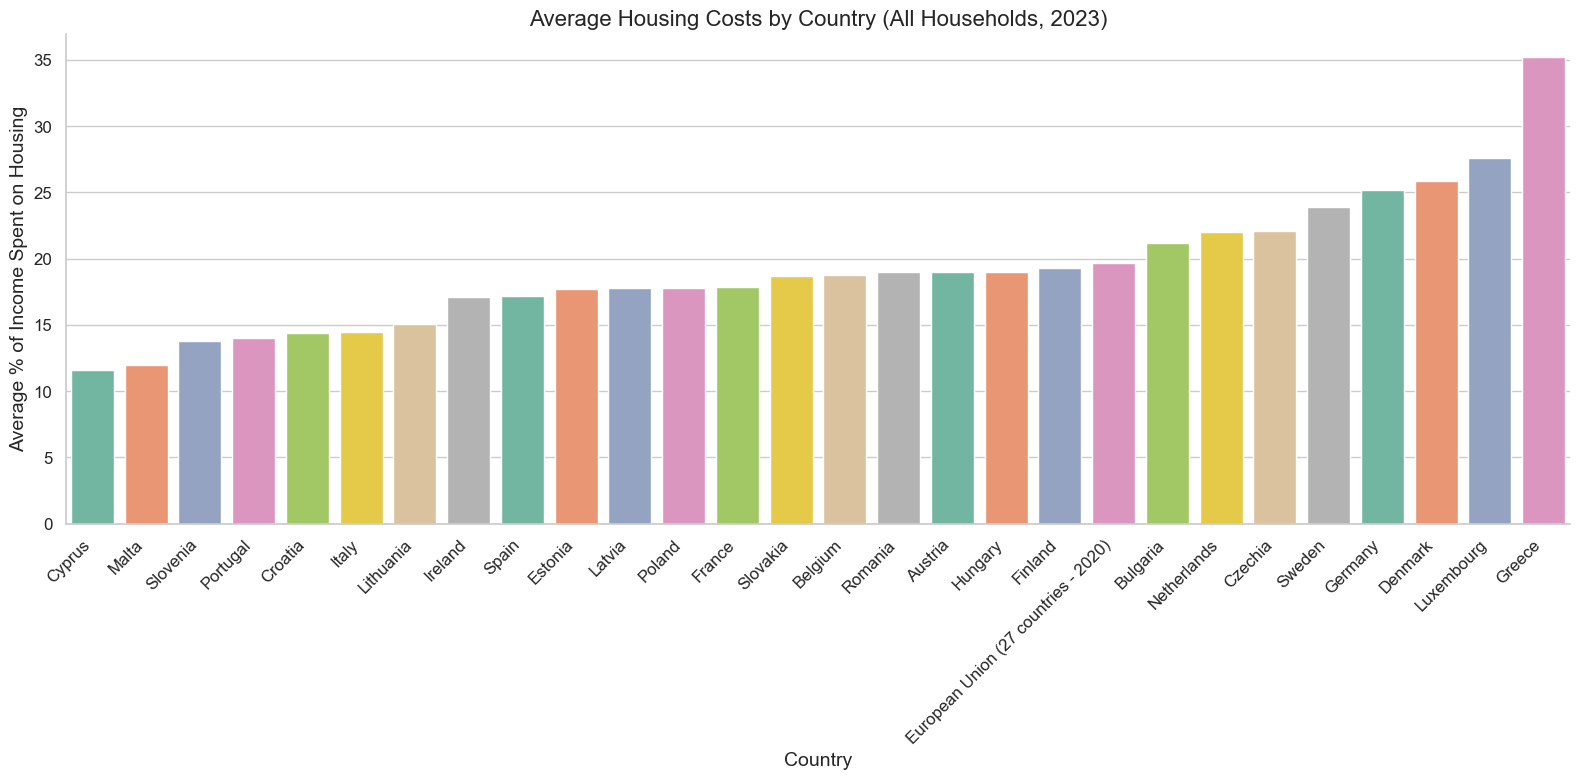

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Professional theme
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

palette = sns.color_palette("Set2")

# ✅ Filter for 2023 & household type TOTAL
df_total_2023 = df_clean[
    (df_clean['TIME_PERIOD'] == 2023) &
    (df_clean['hhtyp'] == 'TOTAL') & (df_clean['incgrp_encoded'] == 'All income groups'  )
].copy()

print(f"Rows for 2023 and household type TOTAL: {df_total_2023.shape[0]}")

# ✅ 1️⃣ Average by Country (household type TOTAL)
country_means = (
    df_total_2023.groupby('geo_encoded')['OBS_VALUE']
    .mean()
    .sort_values()
)

plt.figure(figsize=(16, 8))
sns.barplot(
    x=country_means.index,
    y=country_means.values,
    palette=palette
)
plt.title('Average Housing Costs by Country (All Households, 2023)')
plt.xlabel('Country')
plt.ylabel('Average % of Income Spent on Housing')
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()


C:\Users\lukas\AppData\Local\Temp\ipykernel_8784\159405756.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\lukas\AppData\Local\Temp\ipykernel_8784\159405756.py:15: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(
C:\Users\lukas\AppData\Local\Temp\ipykernel_8784\159405756.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


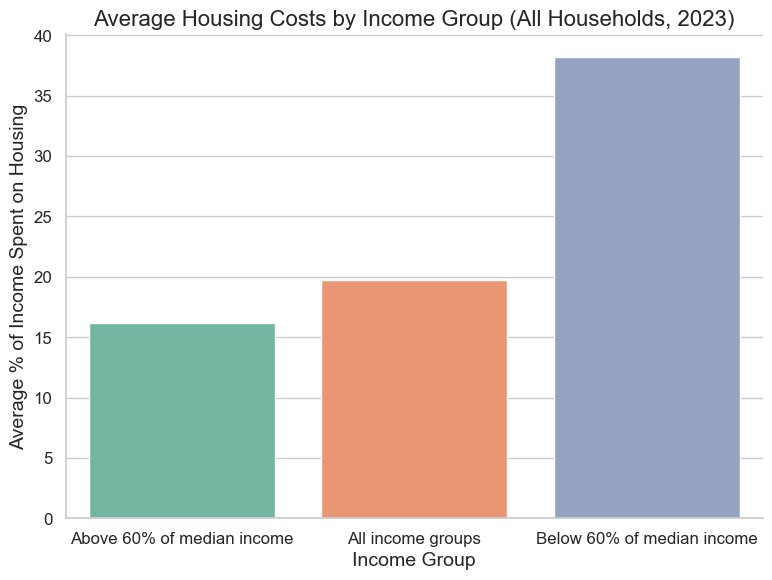

In [10]:
# ✅ Filter for 2023 & household type TOTAL
df_2023_total_EU = df_clean[
    (df_clean['TIME_PERIOD'] == 2023) &
    (df_clean['hhtyp'] == 'TOTAL') & (df_clean['geo_encoded'] == 'European Union (27 countries - 2020)'  )
].copy()

# ✅ 2️⃣ Average by Income Group (household type TOTAL)
income_means = (
    df_2023_total_EU.groupby('incgrp_encoded')['OBS_VALUE']
    .mean()
    .sort_values()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    x=income_means.index,
    y=income_means.values,
    palette=palette
)
plt.title('Average Housing Costs by Income Group (All Households, 2023)')
plt.xlabel('Income Group')
plt.ylabel('Average % of Income Spent on Housing')
sns.despine()
plt.tight_layout()
plt.show()




In [ ]:
df_final = df_final[df_clean['hhtyp'] != 'TOTAL'].copy()
df_final = df_final[df_final['TIME_PERIOD'] == 2023].copy()
df_final = df_final[df_final['geo_encoded'] != 'European Union (27 countries - 2020)'].copy()

NameError: name 'df_final' is not defined

In [ ]:
# One-hot encode categorical variables

X = df_final[['hhtyp_encoded', 'incgrp_encoded', 'geo_encoded']]

X_encoded = pd.get_dummies(
    X[['hhtyp_encoded', 'incgrp_encoded', 'geo_encoded']],
    drop_first=True  # Drop first to avoid multicollinearity
)


#  Final features and target

X_data = X_encoded.values
y_data = df_final['OBS_VALUE_normalized'].values

# After one-hot encoding and normalization:
X_data = X_encoded.to_numpy(dtype='float64')


NameError: name 'df_final' is not defined

In [12]:
 import pymc as pm 
import arviz as az

with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=10, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = intercept + pm.math.dot(X_data, betas)
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_data)

    trace = pm.sample(
        draws=100,
        tune=100,
        target_accept=0.9,
        random_seed=42
    )

# Explore results
az.summary(trace)
az.plot_trace(trace)

NameError: name 'X_data' is not defined